In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import interpolate

In [2]:
def spectrum(R,h,hdu): #esta rutina es para leer los espectros en el punto de la galaxia que querais
    n = len(hdu)
    primary_header = hdu[0].header
    
    Rmin = primary_header['rmin']
    Rmax = primary_header['rmax']
    dimR = primary_header['dimR']
    stepR = round((Rmax-Rmin)/dimR,1)
    
    zmin = primary_header['zmin'] 
    zmax = primary_header['zmax']
    dimz = primary_header['dimz']
    stepz = round((zmax-zmin)/dimz,2)
    
    R_i = int(np.round((R-Rmin)/stepR))
    h_i = int(np.round((h-zmin)/stepz))

    for i in range(1,n):
        if hdu[i].header['A'] == 0 and hdu[i].header['EXTRA'] == 1:
            ext_pos = hdu[i].data[h_i,R_i,:]     #z,r,E (lo pone en el header primario)
        elif hdu[i].header['Z_'] == -1 and hdu[i].header['SEC'] == 0 and hdu[i].header['DM'] == 0:
            prim_elec = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 0 and hdu[i].header['SEC'] == 1 and hdu[i].header['Z_'] == 1:
            sec_pos = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['Z_'] == -1 and hdu[i].header['A'] == 0 and hdu[i].header['SEC'] == 1:
            sec_elec = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['Z_'] == 1 and hdu[i].header['A'] == 1 and hdu[i].header['SEC'] == 0:
            prim_prot = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['Z_'] == 1 and hdu[i].header['A'] == 1 and hdu[i].header['SEC'] == 1:
            sec_prot = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 2 and hdu[i].header['Z_'] == 1:
            H2 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 4 and hdu[i].header['Z_'] == 2:
            He = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 10 and hdu[i].header['Z_'] == 5:
            B10 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 11 and hdu[i].header['Z_'] == 5:
            B11 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 12 and hdu[i].header['Z_'] == 6:
            C12 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 13 and hdu[i].header['Z_'] == 6:
            C13 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 14 and hdu[i].header['Z_'] == 6:
            C14 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 16 and hdu[i].header['Z_'] == 8:
            O16 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 17 and hdu[i].header['Z_'] == 8:
            O17 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 18 and hdu[i].header['Z_'] == 8:
            O18 = hdu[i].data[h_i,R_i,:]
    return ext_pos, sec_pos, prim_elec, sec_elec, prim_prot, sec_prot, He, B10, B11, C12, C13, C14, O16, O17, O18

In [3]:
file = 'NFWsquared.fits.gz'#el nombre del archivo que queramos leer

hdulist = fits.open(file)

prihdr = hdulist[0].header
n_ext = len(hdulist)

table_hdu = hdulist[0]
table_header = table_hdu.header

emin   = table_header['ekmin']
ek_fac = table_header['ekin_fac']
dimE   = table_header['dimE']

E = [emin*(ek_fac**i) for i in range(0,dimE)]
E = np.array(E)

Rmin = table_header['rmin'] #kpc
Rmax = table_header['rmax']
dimR = table_header['dimR']

R = np.linspace(Rmin,Rmax,dimR)
stepR = round((Rmax-Rmin)/dimR,1)

zmin = table_header['zmin'] 
zmax = table_header['zmax']
dimz = table_header['dimz']
z = np.linspace(zmin,zmax,dimz)
stepz = round((zmax-zmin)/dimz,2)

print('Rmin =',Rmin,', Rmax =',Rmax,', stepR =',stepR)
print('zmin =',zmin,', zmax =',zmax,', stepz =',stepz)

Rmin = 0.0 , Rmax = 12.0 , stepR = 0.1
zmin = -18.0 , zmax = 18.0 , stepz = 0.3


In [4]:
#aqui leemos los espectros
ep, sp, pe, se, ppr, spr, He, B10, B11, C12, C13, C14, O16, O17, O18= spectrum(8.3, 0, hdulist)

In [5]:
# aqui tenemos algunas funciones utiles
Elog = np.log(E)
phi = 0.58#el parametro de la modulacion solar

def lepton_modulation(E, Elog, spectrum, potential, m):#modulación solar
    dimE = len(E)
    spectrum_mod = np.zeros(int(dimE))
    A = ((E + m)**2 - m**2) / (((E + m) + potential)**2 - m**2)    
    F = interpolate.InterpolatedUnivariateSpline(Elog, spectrum)
    Elog_shifted = np.zeros(dimE)
    for i in range(dimE):
        Elog_shifted[i] = np.log(E[i] + potential)
    spectrum_mod = A * F(Elog_shifted)
    return spectrum_mod

def proton_modul(E, flux, m, Z, A, phi_nuc, Charge_sign=False, phi_n= 0.7, fluxerr = 0):
        if Charge_sign == True:         
            R0 = 1.
            R = (A/Z) * np.sqrt(E**2 + 2*m*E)
            phi_ = phi_n
            phi_n = phi_nuc + phi_*(R0/R)
            En = E + (Z/A)*phi_n
            mod = E * (E + 2*m) / ((E + (Z/A)*phi_n + m)**2 - m**2)
            flux_mod = np.interp(En, E, flux)*mod
            
        else:
            En = E + (Z/A)*phi_nuc
            mod = E * (E + 2*m) / ((E + (Z/A)*phi_nuc + m)**2 - m**2)
            flux_mod = np.interp(En, E, flux)*mod
        
        if fluxerr != 0: 
            fluxerr_mod = np.interp(En, E, fluxerr)*mod
            return np.array(flux_mod), np.array(fluxerr_mod)
          
        return np.array(flux_mod)#, np.array(fluxerr_mod)
    
def Rig_to_En(R, A, Z, flux, errflux):#para convertir entre rigidity y energía
        m = 0.9315

        Rmean = np.array(R)
        
        #M = A*m
        #T = (np.sqrt((Z*Rmean)**2 + M**2) - M )/A       # T is the Emean!!
        
        T = (np.sqrt((Z*Rmean/A)**2 + m**2) - m )
        dRdE = (A/Z)*(np.array(T)+m)/np.sqrt((np.array(T)**2) + 2. * np.array(T)*m)
        Flux = dRdE * np.array(flux)
        ErrFlux = dRdE * np.array(errflux)
        

        return T, Flux, ErrFlux

def En_to_Rig(E, A, Z, flux, errflux):
        m = 0.9315
            
        Emean = np.array(E)
        R = (A/Z) * np.sqrt(Emean**2 + 2*m*Emean)
        dEdR = (Z/A)**2 * R/((R*Z/A)**2 + m**2)
        Flux = dEdR * np.array(flux)
        ErrFlux = dEdR * np.array(errflux)
        
        return R, Flux, ErrFlux

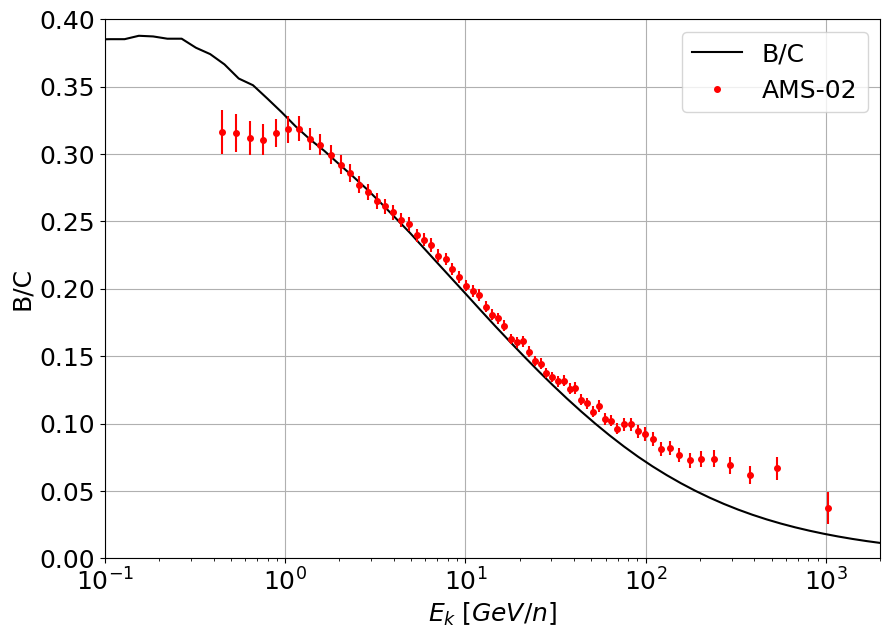

In [6]:
#B/C
um = 0.9315
m_B10 = um * 10
m_B11 = um * 11
m_C12 = um * 12
m_C13 = um * 13
m_C14 = um * 14

B10_c = proton_modul(E, B10, m_B10, 5, 10, phi)
B11_c = proton_modul(E, B11, m_B11, 5, 11, phi)
C12_c = proton_modul(E, C12, m_C12, 6, 12, phi)
C13_c = proton_modul(E, C13, m_C13, 6, 13, phi)
C14_c = proton_modul(E, C14, m_C14, 6, 14, phi)


BC_exp = np.loadtxt('B_C_ratio.txt',usecols=[0,3,4,5])
E_BC = BC_exp[:,0]
flux_BC = BC_exp[:,1]

plt.figure(figsize=(10,7))
plt.plot(E,(B10_c+B11_c)/(C12_c+C13_c+C14_c),'k',label = 'B/C')
plt.plot(E_BC,flux_BC,'ro',markersize = 4, label = 'AMS-02')
plt.errorbar(E_BC,flux_BC, yerr = BC_exp[:,2], fmt = 'none', ecolor='r')
plt.xlabel(r'$E_k \; [GeV/n]$', fontsize = 18)
plt.ylabel('B/C', fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylim(0,0.4)
plt.xlim(1e-1,2e3)
plt.xscale('log')
plt.legend(fontsize=18)
plt.grid()
#plt.savefig('figs_paper/BC.jpg',bbox_inches='tight')
plt.show()

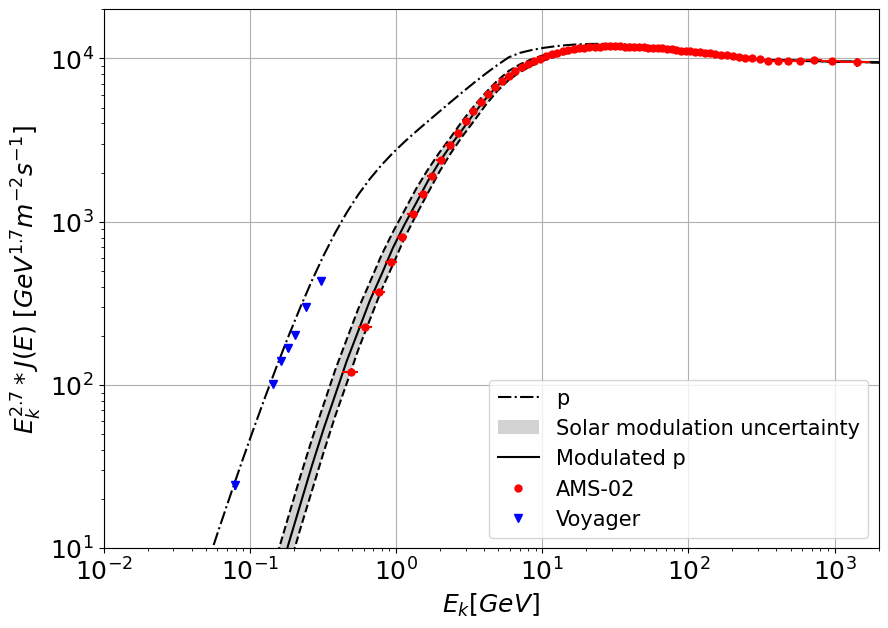

In [7]:
#PROTONES
m_p = 0.938

prot_ams = np.loadtxt('prot_AMS_2011-2013.dat', usecols = [0,3,8,1,2])
prot_voy = np.loadtxt('Voyager1_2012_Proton.dat', usecols = [0,3,8,1,2])

ppr_c = proton_modul(E, ppr+spr, m_p, 1, 1, phi)
ppr_c1 = proton_modul(E, ppr+spr, m_p, 1, 1, phi-0.1)
ppr_c2 = proton_modul(E, ppr+spr, m_p, 1, 1, phi+0.1)

plt.figure(figsize=(10,7))
plt.loglog(E,ppr*E**(2.7),'k-.', label = 'p')
plt.fill_between(E,ppr_c1*E**2.7,ppr_c2*E**2.7,facecolor = 'lightgray',label = r'Solar modulation uncertainty')
plt.loglog(E,ppr_c*E**(2.7),'k', label = 'Modulated p')
plt.loglog(E,ppr_c1*E**(2.7),'k--')
plt.loglog(E,ppr_c2*E**(2.7),'k--')
plt.loglog(prot_ams[:,0],prot_ams[:,1]*(prot_ams[:,0]**2.7),'ro',markersize = 5, label = 'AMS-02')
plt.errorbar(prot_ams[:,0],prot_ams[:,1]*(prot_ams[:,0]**2.7), xerr = (prot_ams[:,4]-prot_ams[:,3])/2, yerr = prot_ams[:,2]*(prot_ams[:,0]**2.7), fmt = 'none',ecolor='r')
plt.loglog(prot_voy[:,0],prot_voy[:,1]*(prot_voy[:,0]**2.7),'bv',markersize = 6, label = 'Voyager')
plt.errorbar(prot_voy[:,0],prot_voy[:,1]*(prot_voy[:,0]**2.7), yerr = prot_voy[:,2]*(prot_voy[:,0]**2.7), fmt = 'none', ecolor='b')
plt.legend(fontsize=15)
plt.ylabel(r'$E_k^{2.7} * J(E) \; [GeV^{1.7} m^{-2} s^{-1}]$', fontsize=18)
plt.xlabel(r'$E_k [GeV]$', fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylim(1e1,2e4)
plt.xlim(1e-2,2e3)
plt.grid()
plt.show()

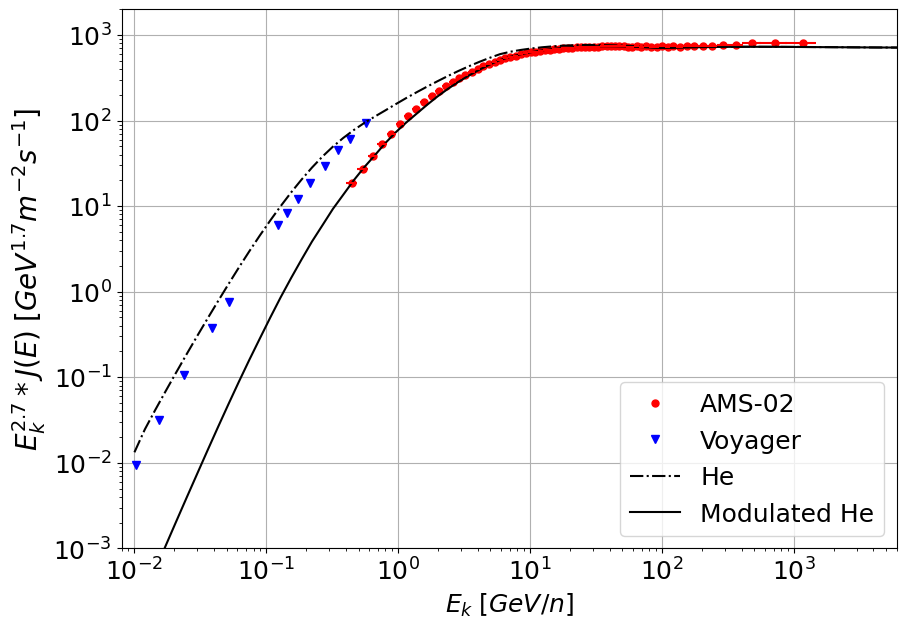

In [8]:
#HELIO

m_he = 4 * m_p
he_c = proton_modul(E, He, m_he, 2, 4, phi)

he_voy = np.loadtxt('Voyager1_Helium.txt',usecols=[2,3,4,0,1])
E_he_voy = he_voy[:,0]/1e3
flux_he_voy = he_voy[:,1]*1e3

he_ams = np.loadtxt('He_AMS_2011-2013.dat',usecols=[0,3,8,1,2])
E_he_ams = he_ams[:,0]
flux_he_ams = he_ams[:,1]

plt.figure(figsize=(10,7))
plt.loglog(E_he_ams,flux_he_ams*E_he_ams**(2.7),'ro',markersize = 5, label = 'AMS-02')
plt.loglog(E_he_voy,flux_he_voy*E_he_voy**(2.7),'bv',markersize = 6, label = 'Voyager')
plt.loglog(E,He*E**(2.7),'k-.',label = 'He')
plt.loglog(E,he_c*E**(2.7),'k-',label = 'Modulated He')
plt.errorbar(he_ams[:,0],he_ams[:,1]*(he_ams[:,0]**2.7), xerr = (he_ams[:,4]-he_ams[:,3])/2, yerr = he_ams[:,2]*(he_ams[:,0]**2.7), fmt = 'none',ecolor='r')
plt.errorbar(E_he_voy,flux_he_voy*(E_he_voy**2.7), yerr = he_voy[:,2]*1e3*(E_he_voy**2.7), fmt = 'none', ecolor='b')
plt.ylabel(r'$E_k^{2.7} * J(E) \; [GeV^{1.7} m^{-2} s^{-1}]$', fontsize=20)
plt.xlabel(r'$E_k \;[GeV/n]$', fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylim(1e-3,2e3)
plt.xlim(8e-3,6e3)
plt.legend(fontsize = 18)
plt.grid()
plt.show()

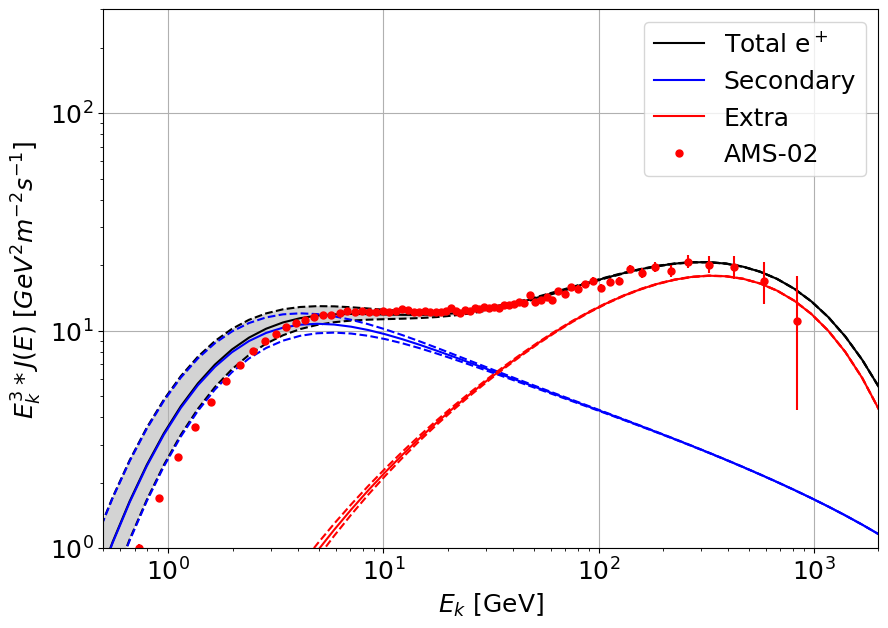

In [9]:
#POSITRONES
m_e = 0.51099e-3

pos = lepton_modulation(E, Elog, sp+ep/2, phi, m_e)
pos1 = lepton_modulation(E, Elog, sp+ep/2, phi-0.1, m_e)
pos2 = lepton_modulation(E, Elog, sp+ep/2, phi+0.1, m_e)

sp_c = lepton_modulation(E, Elog, sp, phi, m_e)
sp_c1 = lepton_modulation(E, Elog, sp, phi-0.1, m_e)
sp_c2 = lepton_modulation(E, Elog, sp, phi+0.1, m_e)

ep_c = lepton_modulation(E, Elog, ep/2, phi, m_e)
ep_c1 = lepton_modulation(E, Elog, ep/2, phi-0.1, m_e)
ep_c2 = lepton_modulation(E, Elog, ep/2, phi+0.1, m_e)

pos_exp = np.loadtxt('positron_data.txt',usecols=[5,8,9])
E_pos = pos_exp[:,0]
flux_pos = pos_exp[:,1]
err_pos = pos_exp[:,2]

plt.figure(figsize=(10,7))
plt.loglog(E,pos*E**3,'k',label=r'Total e$^+$')
plt.loglog(E,pos1*E**3,'k--')
plt.loglog(E,pos2*E**3,'k--')
plt.fill_between(E,pos1*E**3,pos2*E**3,facecolor = 'lightgray')
plt.loglog(E,sp_c*E**3,'b',label='Secondary')
plt.loglog(E,sp_c1*E**3,'b--')
plt.loglog(E,sp_c2*E**3,'b--')
#plt.fill_between(E,sp_c1*E**3,sp_c2*E**3,facecolor = 'lightgray')
plt.loglog(E,ep_c*E**3,'r',label='Extra')
plt.loglog(E,ep_c1*E**3,'r--')
plt.loglog(E,ep_c2*E**3,'r--')
plt.loglog(E_pos,flux_pos*(E_pos**3),'ro',markersize=5,label = 'AMS-02')
plt.errorbar(E_pos,flux_pos*(E_pos**3), yerr = err_pos*(E_pos**3), fmt = 'none',ecolor = 'r')
#plt.fill_between(E,ep_c1*E**3,ep_c2*E**3,facecolor = 'lightgray')
plt.legend(fontsize = 18)
plt.ylabel(r'$E_k^3 * J(E)\;[GeV^{2} m^{-2} s^{-1}]$', fontsize = 18)
plt.xlabel(r'$E_k$ [GeV]', fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylim(1e0,3e2)
plt.xlim(5e-1,2e3)
plt.grid()
plt.show()

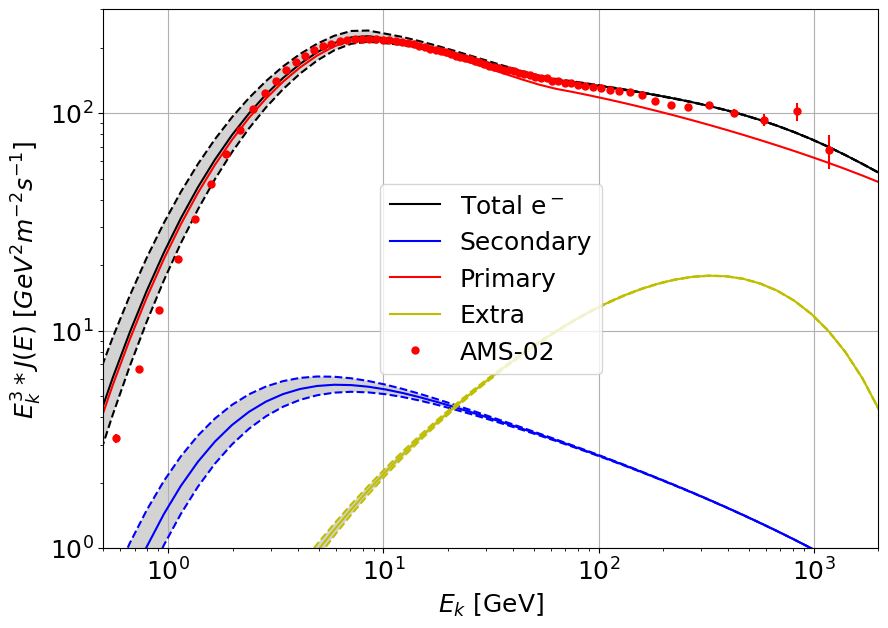

In [10]:
#ELECTRONS

elec_exp = np.loadtxt('electron_data.txt',usecols=[5,8,9])
E_e = elec_exp[:,0]
flux_e = elec_exp[:,1]
err_e = elec_exp[:,2]

pe_c = lepton_modulation(E, Elog, pe, phi, m_e)
se_c = lepton_modulation(E, Elog, se, phi, m_e)
pe_c1 = lepton_modulation(E, Elog, pe, phi+0.1, m_e)
se_c1 = lepton_modulation(E, Elog, se, phi+0.1, m_e)
pe_c2 = lepton_modulation(E, Elog, pe, phi-0.1, m_e)
se_c2 = lepton_modulation(E, Elog, se, phi-0.1, m_e)

e_c = lepton_modulation(E,Elog,pe+se+ep/2,phi,m_e)
e_c1 = lepton_modulation(E,Elog,pe+se+ep/2,phi+0.1,m_e)
e_c2 = lepton_modulation(E,Elog,pe+se+ep/2,phi-0.1,m_e)



plt.figure(figsize=(10,7))
plt.loglog(E,e_c*E**3,'k',label=r'Total e$^-$')
plt.loglog(E,e_c1*E**3,'k--')
plt.loglog(E,e_c2*E**3,'k--')
plt.fill_between(E,e_c1*E**3,e_c2*E**3,facecolor = 'lightgray')
plt.loglog(E,se_c*E**3,'b',label='Secondary')
plt.fill_between(E,se_c1*E**3,se_c2*E**3,facecolor = 'lightgray')
plt.loglog(E,se_c1*E**3,'b--')
plt.loglog(E,se_c2*E**3,'b--')
plt.loglog(E,pe_c*E**3, 'r',label='Primary')
#plt.loglog(E,pe_c1*E**3, 'r--')
#plt.loglog(E,pe_c2*E**3, 'r--')
plt.loglog(E,ep_c*E**3,'y',label='Extra')
plt.loglog(E,ep_c1*E**3,'y--')
plt.loglog(E,ep_c2*E**3,'y--')
plt.fill_between(E,ep_c1*E**3,ep_c2*E**3,facecolor = 'lightgray')
plt.loglog(E_e,flux_e*(E_e**3),'ro',markersize=5,label = 'AMS-02')
plt.errorbar(E_e,flux_e*(E_e**3), yerr = err_e*(E_e**3), fmt = 'none',ecolor = 'r')
plt.legend(fontsize = 18)
plt.ylabel(r'$E_k^3 * J(E)\;[GeV^{2} m^{-2} s^{-1}]$', fontsize = 18)
plt.xlabel(r'$E_k$ [GeV]', fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylim(1e0,3e2)
plt.xlim(5e-1,2e3)
plt.grid()
plt.show()